# Introduction

In this tutorial, we will compare Kernel Ridge Regression (KRR) and Support Vector Regression (SVR) using Scikit-Learn, a popular machine learning library in Python. Both models learn a non-linear function by employing the kernel trick. KRR and SVR differ in their loss functions and fitting methods. We will use an artificial dataset consisting of a sinusoidal target function and strong noise added to every fifth datapoint.



# Generate Sample Data

Generate Sample Data

In [1]:
import numpy as np

# Generate sample data
rng = np.random.RandomState(42)
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

# Construct the Kernel-based Regression Models

We will construct KRR and SVR models using Scikit-Learn's GridSearchCV to find the best hyperparameters.

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

train_size = 100

# SVR Model
svr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
)

# KRR Model
kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

# Compare Times of SVR and Kernel Ridge Regression

We will compare the fitting and prediction times of SVR and KRR models using the best hyperparameters found in Step 2.

In [3]:
import time

# Fit SVR
t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0

# Print the best params and score for SVR model
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

# Fit KRR
t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0

# Print the best params and score for KRR model
print(f"Best KRR with params: {kr.best_params_} and R2 score: {kr.best_score_:.3f}")
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

# Compute the support vector ratio for SVR
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

# Predict using SVR
t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s" % (X_plot.shape[0], svr_predict))

# Predict using KRR
t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (X_plot.shape[0], kr_predict))

Best SVR with params: {'C': 1.0, 'gamma': 0.1} and R2 score: 0.737
SVR complexity and bandwidth selected and model fitted in 0.320 s
Best KRR with params: {'alpha': 0.1, 'gamma': 0.1} and R2 score: 0.723
KRR complexity and bandwidth selected and model fitted in 0.277 s
Support vector ratio: 0.340
SVR prediction for 100000 inputs in 0.088 s
KRR prediction for 100000 inputs in 0.076 s


# Look at the Results

We will visualize the learned model of KRR and SVR when both complexity/regularization and bandwidth of the RBF kernel are optimized using grid-search.

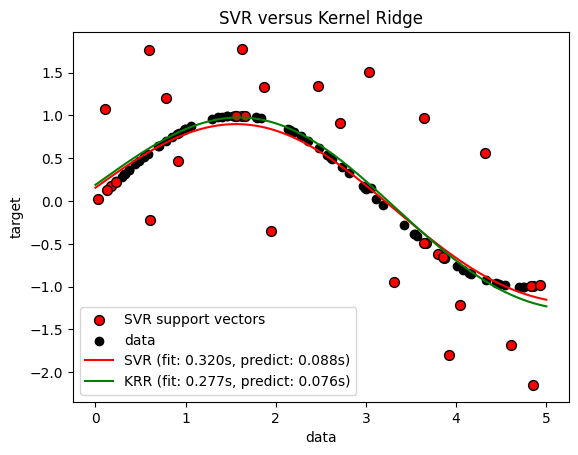

In [4]:
import matplotlib.pyplot as plt

sv_ind = svr.best_estimator_.support_
plt.scatter(
    X[sv_ind],
    y[sv_ind],
    c="r",
    s=50,
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0),
)
plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))
plt.plot(
    X_plot,
    y_svr,
    c="r",
    label="SVR (fit: %.3fs, predict: %.3fs)" % (svr_fit, svr_predict),
)
plt.plot(
    X_plot, y_kr, c="g", label="KRR (fit: %.3fs, predict: %.3fs)" % (kr_fit, kr_predict)
)
plt.xlabel("data")
plt.ylabel("target")
plt.title("SVR versus Kernel Ridge")
_ = plt.legend()

# Visualize Training and Prediction Times

We will visualize the time for fitting and prediction of KRR and SVR for different sizes of the training set.

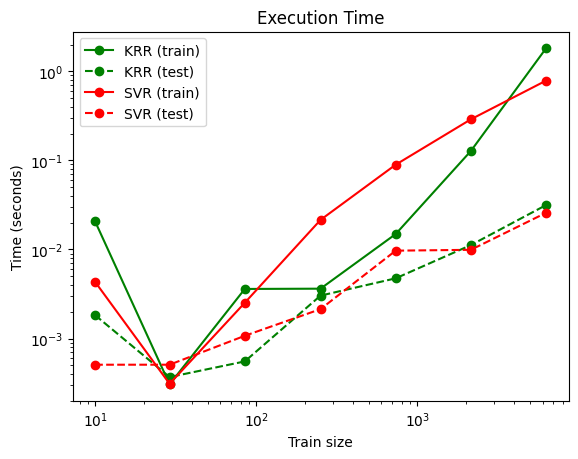

In [5]:
_, ax = plt.subplots()

sizes = np.logspace(1, 3.8, 7).astype(int)
for name, estimator in {
    "KRR": KernelRidge(kernel="rbf", alpha=0.01, gamma=10),
    "SVR": SVR(kernel="rbf", C=1e2, gamma=10),
}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(
        sizes,
        train_time,
        "o-",
        color="r" if name == "SVR" else "g",
        label="%s (train)" % name,
    )
    plt.plot(
        sizes,
        test_time,
        "o--",
        color="r" if name == "SVR" else "g",
        label="%s (test)" % name,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title("Execution Time")
_ = plt.legend(loc="best")

# Visualize the Learning Curves

We will visualize the learning curves of KRR and SVR.

/var/folders/xl/cw1gsh4s5398kfn_9w27_tmc0000gn/T/ipykernel_24192/3557760679.py:22: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax.legend(handles=ax.get_legend_handles_labels()[0], labels=["SVR", "KRR"])


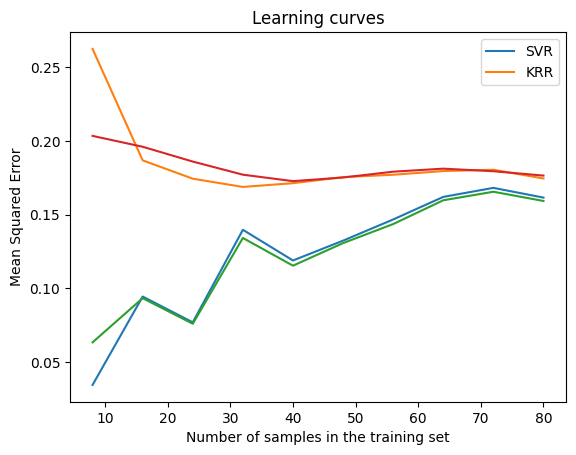

In [6]:
from sklearn.model_selection import LearningCurveDisplay

_, ax = plt.subplots()

svr = SVR(kernel="rbf", C=1e1, gamma=0.1)
kr = KernelRidge(kernel="rbf", alpha=0.1, gamma=0.1)

common_params = {
    "X": X[:100],
    "y": y[:100],
    "train_sizes": np.linspace(0.1, 1, 10),
    "scoring": "neg_mean_squared_error",
    "negate_score": True,
    "score_name": "Mean Squared Error",
    "std_display_style": None,
    "ax": ax,
}

LearningCurveDisplay.from_estimator(svr, **common_params)
LearningCurveDisplay.from_estimator(kr, **common_params)
ax.set_title("Learning curves")
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=["SVR", "KRR"])

plt.show()

# Summary

In this tutorial, we compared Kernel Ridge Regression (KRR) and Support Vector Regression (SVR) using Scikit-Learn. We generated a dataset consisting of a sinusoidal target function and strong noise added to every fifth datapoint. We constructed KRR and SVR models using Scikit-Learn's GridSearchCV to find the best hyperparameters. We compared the fitting and prediction times of SVR and KRR models using the best hyperparameters found. We visualized the learned model of KRR and SVR when both complexity/regularization and bandwidth of the RBF kernel are optimized using grid-search. We also visualized the time for fitting and prediction of KRR and SVR for different sizes of the training set. Finally, we visualized the learning curves of KRR and SVR.